In [1]:
!pip install -U databento
!pip install tabulate

In [126]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import databento as db
import pandas as pd
import numpy as np
import math
from tabulate import tabulate
from pathlib import Path

import warnings
# Ignore all warnings
warnings.simplefilter(action='ignore', category=Warning)

# Set the style to 'dark_background'
plt.style.use('dark_background')

In [30]:
def get_mbp_data(dataset: str, start: str, end: str, symbol: str):

    """
    MBP (market by price) provides changes to and snapshots of aggregated book depth, keyed by price. 
    This is limited to a fixed number of levels from the top. We denote number of levels displayed 
    in the schema with a suffix, such as mbp-1 and mbp-10.
    """
    # Schema: it is a data record format represented as a collection of different data fields.
    # Timestamp format: YYYY-MM-DDTHH:MM  T: This is a separator that indicates the start of the time portion.

    client = db.Historical("db-SEbmRhQ3ekjnrdRQLfK4iDYJhVkrL")
    data_mbp = client.timeseries.get_range(
        dataset=dataset,
        start=start,
        end=end,
        symbols=symbol,
        schema="mbp-10"
    )

    data_mbp = data_mbp.to_df()
    # ts_event: this represents the time that the event is received by the matching engine.
    data_mbp = data_mbp.set_index('ts_event')

    """
    ts_recv: The capture-server-received timestamp expressed as the number of nanoseconds since the UNIX epoch.
    ts_event: The matching-engine-received timestamp expressed as the number of nanoseconds since the UNIX epoch.
    rtype: The record type. Each schema corresponds with a single rtype value.
    publisher_id: The publisher ID assigned by Databento, which denotes dataset and venue.
    instrument_id: The numeric instrument ID.
    action: The event action. Can be [A]dd, [C]ancel, [M]odify, clea[R] book, or [T]rade.
    side: The order side. Can be [A]sk, [B]id or [N]one.
    depth: The book level where the update event occurred.
    price: The order price expressed as a signed integer where every 1 unit corresponds to 1e-9, i.e. 1/1,000,000,000 or 0.000000001.
    size: The order quantity.
    flags: A combination of packet end with matching engine status.
    ts_in_delta: The matching-engine-sending timestamp expressed as the number of nanoseconds before ts_recv.
    sequence: The message sequence number assigned at the venue.
    bid_px_N: The bid price at level N (top level if N=00).
    ask_px_N: The ask price at level N (top level if N=00).
    bid_sz_N: The bid size at level N (top level if N=00).
    ask_sz_N: The ask size at level N (top level if N=00).
    bid_ct_N: The number of bid orders at level N (top level if N=00).
    ask_ct_N: The number of ask orders at level N (top level if N=00).
    action: The event action. Will always be [T]rade in the TBBO schema.
    side: The aggressing order's side in the trade. Can be [A]sk, [B]id or [N]one.
    depth: The book level where the update event occurred.
    price: The order price expressed as a signed integer where every 1 unit corresponds to 1e-9, i.e. 1/1,000,000,000 or 0.000000001.
    size: The order quantity.
    bid_px_00: The bid price at the top level.
    ask_px_00: The ask price at the top level.
    bid_sz_00: The bid size at the top level.
    ask_sz_00: The ask size at the top level.
    bid_ct_00: The number of bid orders at the top level.
    ask_ct_00: The number of ask orders at the top level
    """
    
    return data_mbp

In [31]:
# ========================================== Data Example ==============================================

# High liquidity, high traded volume
df_sample = get_mbp_data(dataset="XNAS.ITCH", start="2022-06-02T09:30", end="2022-06-02T16:00", symbol="TSLA")

df_sample = df_sample[["symbol", "action", "side", "depth", "price", "size", "bid_px_00", "ask_px_00", "bid_sz_00", "ask_sz_00",
                 "bid_ct_00", "ask_ct_00", "bid_px_01", "ask_px_01", "bid_sz_01", "ask_sz_01", "bid_ct_01", "ask_ct_01"]]

# Convert DataFrame to tabulated format and print
print("Trades DataFrame for DENN")
print(tabulate(df_sample.head(5), headers="keys", tablefmt="fancy_grid"))

Trades DataFrame for DENN
╒═════════════════════════════════════╤══════════╤══════════╤════════╤═════════╤═════════╤════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ ts_event                            │ symbol   │ action   │ side   │   depth │   price │   size │   bid_px_00 │   ask_px_00 │   bid_sz_00 │   ask_sz_00 │   bid_ct_00 │   ask_ct_00 │   bid_px_01 │   ask_px_01 │   bid_sz_01 │   ask_sz_01 │   bid_ct_01 │   ask_ct_01 │
╞═════════════════════════════════════╪══════════╪══════════╪════════╪═════════╪═════════╪════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 2022-06-02 09:30:03.965999074+00:00 │ TSLA     │ C        │ A      │       4 │  745    │      7 │         744 │       744.5 │         100 │         769 │           1 │ 

In [123]:
# Calculate mid price per minute
def get_mid_price(df_input: pd.DataFrame, type_mid: str, resample_freq="1T"):
    # Set up a copy of the DataFrame
    df = df_input.copy()

    # Initialize return DataFrame
    return_df = pd.DataFrame()

    # Calculate the mid-price using the last observation
    if type_mid == "last": 
        df_resampled = df.resample(resample_freq).last().dropna()
        return_df[f"mid-price_{type_mid}"] = (df_resampled["bid_px_00"] + df_resampled["ask_px_00"]) * 0.5
        return return_df
    
    # Calculate the mid-price as the average mid-price during the resample_freq
    if type_mid == "mean":
        return_df[f"mid-price_{type_mid}"] = (df["bid_px_00"] + df["ask_px_00"]) * 0.5
        return_df = return_df.resample(resample_freq).mean().dropna()
        return return_df
    
    # Calculate the mid-price using Volume Weighted Mid-Price (VWMP)
    if type_mid == "vwmp":
        df["vwbp_denominator"] = (df["bid_px_00"] * df["bid_sz_00"])
        df["vwap_denominator"] = (df["ask_px_00"] * df["ask_sz_00"])
        # Resample by 1-minute frequency and calculate both sum and count
        df_resampled = df.resample(resample_freq).agg(['sum', 'count'])
        # Flatten the MultiIndex for easier filtering
        df_resampled.columns = ['_'.join(col).strip() for col in df_resampled.columns.values]
        # Create a mask to filter rows where the sum is 0 and count is 0 for all columns
        mask = np.all([(df_resampled[f"{col}_sum"] == 0) & (df_resampled[f"{col}_count"] == 0) for col in df.columns], axis=0)
        # Apply the mask to filter out rows
        df_resampled = df_resampled.loc[~mask]
        # Volume Weighted Bid Price
        vwbp = df_resampled["vwbp_denominator_sum"] / df_resampled["bid_sz_00_sum"]
        # Volume Weighted Ask Price
        vwap = df_resampled["vwap_denominator_sum"] / df_resampled["ask_sz_00_sum"]
        return_df[f"mid-price_{type_mid}"] = (vwbp + vwap) * 0.5

        return return_df

def calculate_return(df_input: pd.DataFrame, column_name: str):
    # Set up a copy of the DataFrame
    df = df_input.copy()
    # Calculate the log returns
    df['log_return'] = np.log(df[column_name] / df[column_name].shift(1))
    # Remove first row with nan
    df = df.iloc[1:,:]
    return df

def calculate_rolling_sigma_squared(df_input: pd.DataFrame, column_name: str, k: int):
    # Set up a copy of the DataFrame
    df = df_input.copy()

    # Create new column for sigma squared with nan
    df["sigma_squared"] = np.nan
    # Get the integer position of the column label
    column_index = df.columns.get_loc(column_name)
    
    # Ensure the time series is long enough for a rolling window of size K
    if len(df) < k + 1:
        return "Time series is too short for the given window size."
    
    for t in range(k, len(df)):
        sigma_squared = 0
        for i in range(1, k + 1):
            sigma_squared += abs(df.iat[t - i, column_index]) * abs(df.iloc[t - i + 1, column_index])
        sigma_squared *= math.pi / (2 * k)
        df.iat[t, len(df.columns)-1] = sigma_squared
    
    # Remove first K rows with nan
    df = df.iloc[k:,:]

    return df

def rolling_std(df_input, column_name, window_size):
    """
    Create a rolling object with a given window size and minimum period 1
    min_periods: specifies the minimum number of non-NA/null observations in the window required to have a valid result.
    """
    # Set up a copy of the DataFrame
    df = df_input.copy()
    
    if window_size < 3:
        print("The window size should be greater than 3")
        
    # Calculate the standard deviation
    df['rolling_std'] = df[column_name].rolling(window=window_size, min_periods=1, center=True).std()
    
    return df

def periodicity_estimator_taylor_and_xu(df_input, window_size, count_days):
    """
    The non-parametric periodicity estimator proposed by Taylor and Xu (1997) is based on the standard deviation (SD) of all
    standardized returns belonging to the same local window
    """
    # Set up a copy of the DataFrame
    df = df_input.copy()
    # Calculate frequency
    df["across_days_std"] = [df[df.index.time == i]["log_return"].std() for i in pd.unique(df.index.time)] * count_days
    df["across_days_std_2"] = df["across_days_std"] ** 2
    
    kwargs = {'column_name': "across_days_std_2", "window_size": window_size} # Additional parameters as keyword arguments
    df = df.groupby(df.index.date, group_keys=False).apply(rolling_std, **kwargs)

    # Calculate the peridicity estimator
    df["periodicity"] = df["across_days_std"] / np.sqrt(df["rolling_std"] / window_size)
    
    # Drop columns
    df.drop(columns=["across_days_std", "across_days_std_2", "rolling_std"], inplace=True)
    
    return df


In [124]:
def build_data_set(date: datetime, end_hour: int, end_minute: int, t_days: int, symbol: str):
    """
    date: datetime object datetime(YYYY, MM, DD, HH, MM) for (MM/DD/YYYY), at HH:MM AM
    """
    # Create return DataFrame
    data_df = pd.DataFrame()
    
    count_days = 0
            
    # Loop through t_days
    for i in range(t_days):
        # Calculate the right dates
        start = date + timedelta(days=i)
        end = date + timedelta(days=i)
        end = end.replace(hour=end_hour, minute=end_minute, second=0, microsecond=0)
        # Convert to ISO 8601 format and remove the seconds part
        start_iso = start.isoformat()[:16]
        end_iso = end.isoformat()[:16]
        # Get data
        data = get_mbp_data(dataset="XNAS.ITCH", start=start_iso, end=end_iso, symbol=symbol)
        
        if len(data.index) != 0:
            count_days += 1
            # Concatenate vertically
            data_df = pd.concat([data_df, data], axis=0)
            
    return data_df, count_days


In [131]:
# Parameters ============
tickers = ["TSLA"]
# build_data_set()
date = datetime(2019, 1, 1, 9, 30)
end_hour = 16
end_minute = 0
t_days = 365 # Should be greater than 2

# Loop to create multiple DataFrames
for ticker in tickers:
    
    # Set up a copy of the DataFrame
    df = pd.DataFrame()
    
    # Create a DataFrame
    df, count_days = build_data_set(date=date, end_hour=end_hour, end_minute=end_minute, t_days=t_days, symbol=ticker)
    
    # Define the path
    path = Path("./data_files") / f"df_mkt_hours_{ticker}.csv"
    # Write DataFrame to CSV
    df.to_csv(path, index=True)

In [137]:
# Load the CSV file into a DataFrame
df = pd.read_csv("./data_files/df_mkt_hours_TSLA.csv")

# Display the first few rows of the DataFrame
print(df.head())

MemoryError: Unable to allocate 10.7 GiB for an array with shape (48, 29843621) and data type int64

In [127]:
# Initialize an empty dictionary to hold the DataFrames
dfs = {}

# Parameters ============
tickers = ["TSLA"]
# build_data_set()
date = datetime(2023, 9, 2, 9, 30)
end_hour = 9
end_minute = 40
t_days = 4 # Should be greater than 2
# get_mid_price()
type_mid = "vwmp"
# calculate_rolling_sigma_squared()
k = 3
# periodicity_estimator_taylor_and_xu()
window_size = 3

# Loop to create multiple DataFrames
for ticker in tickers:
    
    # Set up a copy of the DataFrame
    df = pd.DataFrame()
    
    # Create a DataFrame
#     df, count_days = build_data_set(date=date, end_hour=end_hour, end_minute=end_minute, t_days=t_days, symbol=ticker)


    
    # Calculate the mid-price
    df = get_mid_price(df_input=df, type_mid=type_mid)

    # Calculate the log-return
    df = calculate_return(df_input=df, column_name=f"mid-price_{type_mid}")
     
    # Calculate squared sigma
    df = calculate_rolling_sigma_squared(df_input=df, column_name="log_return", k=k)
    # Calculate sigma
    df["sigma"] = np.sqrt(df["sigma_squared"])

    # Remove the first day of the data to remove missing data
    df = df[df.index.date != date.date()]
    
    # Calculate frequency on column "periodicity"
    df = periodicity_estimator_taylor_and_xu(df_input=df, window_size=window_size, count_days=count_days)
    
    # Calculate the Jump score
    df["jump_score"] = df["log_return"] / (df["sigma"] * df["periodicity"])
    
    # Define the path
    path = Path("./data_files") / f"df_{ticker}.csv"
    # Write DataFrame to CSV
    df.to_csv(path, index=True)

    dfs[f'df_{ticker}'] = df

dfs['df_TSLA'].head()

,mid-price_vwmp,log_return,sigma_squared,sigma,periodicity,jump_score
ts_event,,,,,,
2023-09-05 09:34:00+00:00,244.892778,0.000789,2.559773e-07,0.000506,NaN,NaN
2023-09-05 09:35:00+00:00,244.925164,0.000132,2.331513e-07,0.000483,NaN,NaN
2023-09-05 09:36:00+00:00,244.937045,0.000049,1.760336e-07,0.000420,NaN,NaN
2023-09-05 09:37:00+00:00,245.242471,0.001246,8.963720e-08,0.000299,NaN,NaN
2023-09-05 09:38:00+00:00,245.407876,0.000674,4.749422e-07,0.000689,NaN,NaN


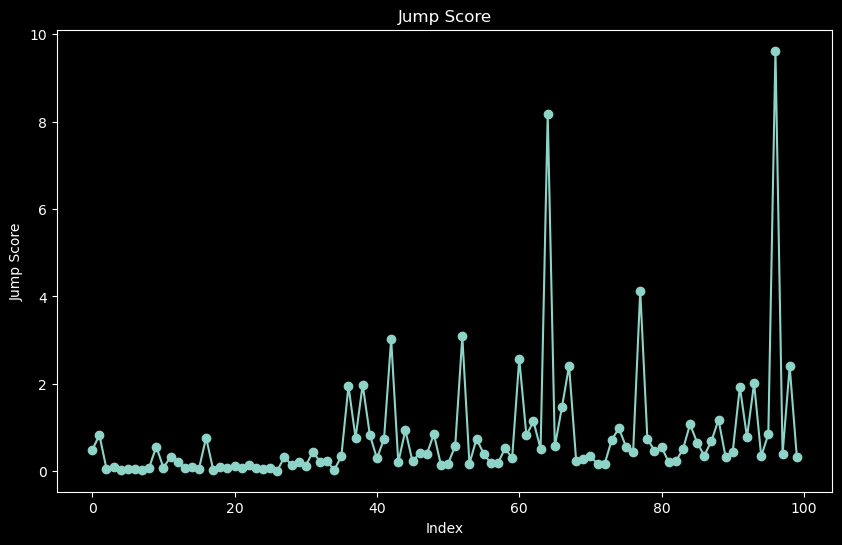

In [15]:
# Create a new figure with a custom size (width=10, height=6)
plt.figure(figsize=(10, 6))
# Create the plot
plt.scatter(range(len(dfs['df_TSLA'].index[200:300])), abs(dfs['df_TSLA']["jump_score"][200:300]))
plt.plot(range(len(dfs['df_TSLA'].index[200:300])), abs(dfs['df_TSLA']["jump_score"][200:300]))
# Add title and labels
plt.title('Jump Score')
plt.xlabel('Index')
plt.ylabel('Jump Score')

# Show the plot
plt.show()

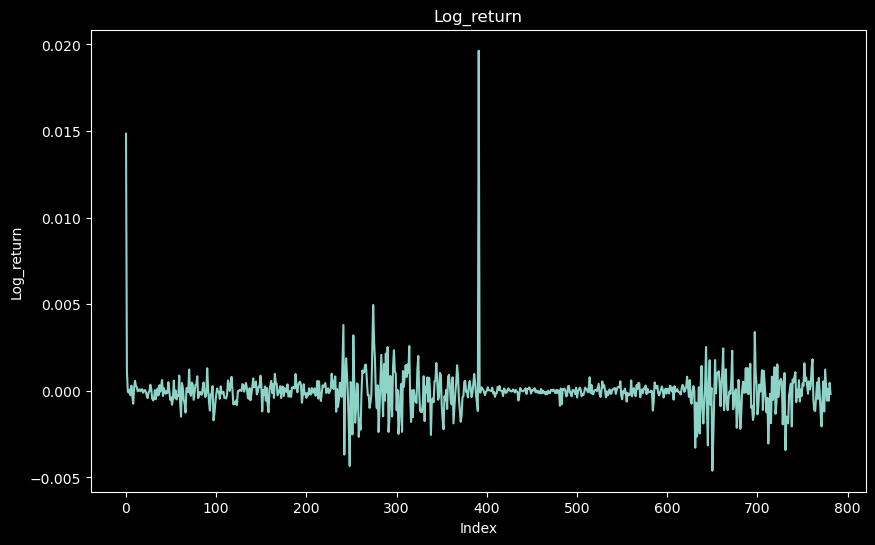

In [9]:
# Create a new figure with a custom size (width=10, height=6)
plt.figure(figsize=(10, 6))
# Create the plot
plt.plot(range(len(dfs['df_TSLA'].index)), dfs['df_TSLA']["log_return"])
# Add title and labels
plt.title('Log_return')
plt.xlabel('Index')
plt.ylabel('Log_return')

# Show the plot
plt.show()

In [10]:
# PIPELINE:
# Get news data characterised by its title, timestamp, and a list of tickers
# Calculate the mid-price time series DONE
# Calculate the 1-minute return time series DONE
# Calculate the local volatility over a rolling time window of length K = 390
# Compute the “jump-scores”
# Use the Gumbel distribution and the "Extreme Value Theory" to identify jumps
## Change from analyzing single jumps to clusters of them
# Use the inter-time distribution to compare with Bernouilli null-hypothesis on jumps occurring with probability p to cluster jumps
# Use the same technique to cluster news
# Mark as news related (or exogenous) those clusters of jumps which started up to one minute before and up to four minutes after the beginning of a cluster of news.
# Remove market-wide or sector-wide news (affecting more than 10% - 30 stocks)
# Remove any cluster of jumps happening within 100 minutes to account for contamination effect
# Claculate Kendall's correlation to characterize the structure of the internal structure of clusters
# Characterize EMC and SEC jumps profiles using the following 5 measures: 1. Instantaneous jump-score. 2. Exponential moving average of past excess volatilty. 3.  Normalized past price trend. 4. Binarized past price trend. 5. Instantaneous average LOB sparsity.



# Implement: w only keep trading days with at least 300 recorded price changes

Sample: consists of $T$ days of $M$ equally spaced and continuously compounded intraday return observations $r_i(i=1, \ldots, M T)$ of a financial asset. We normalize the length of one trading day to unity such that $\Delta=1 / M$ equals the time elapsed between two consecutive return observations. Hence, $r_i$ equals the return over the time interval $[(i-1) \Delta, i \Delta]$.

The local windows: obtained by a division of $[0, T]$ in time intervals of length $\lambda$. As such, the $MT$ observations are divided in groups of $\lfloor\lambda / \Delta\rfloor$ contiguous observations (i.e. $\lfloor 3.7\rfloor=3$).

$N_i$: collection of indices $j$ that belong to the same window as $i$.

Standardization condition: the squared periodicity factor has mean one over the local window thus implies that for all $i=1, \ldots, TM$
$$
\frac{1}{\lfloor\lambda / \Delta\rfloor} \sum_{j \in N_i} f_j^2=1 .
$$




The next question addresses how to disentangle jumps from the continuous component. For this purpose, measures of diffusive volatility are necessary. Barndorff-Nielsen and Shephard (2004) tackle this issue by proposing the bipower variation (BPV) measure, which is computed as the scaled summation of the product of adjacent absolute returns. The BPV is a consistent estimator of integrated volatility, and allows to decompose the realized volatility into its diffusive and non-diffusive parts. As the sampling frequency increases, the presence of jumps should have no impact, because the return representing the jump is multiplied by a non-jump return which tends to zero asymptotically. This is true in case of rare jumps (one each day), when the probability of two consecutive jumps is negligible.

The estimator of Taylor and Xu (1997) is basically the sd across i of a given time of a given day over sd or the local window. 